In [78]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

## Первые строки таблиц и значение атрибутов

In [2]:
lectures = pd.read_csv("data/lectures.csv")
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


* lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).
* tag: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.
* part: top level category code for the lecture.
* type_of: brief description of the core purpose of the lecture.

In [3]:
questions = pd.read_csv("data/questions.csv")
questions.head(10)

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
5,5,5,2,1,131 149 162 81
6,6,6,2,1,10 94 162 92
7,7,7,0,1,61 110 162 29
8,8,8,3,1,131 13 162 92
9,9,9,3,1,10 164 81


* question_id: foreign key for the train/test content_id column, when the content type is question (0).
* bundle_id: code for which questions are served together.
* correct_answer: the answer to the question. Can be compared with the train user_answer column to check if the user was right.
* part: the relevant section of the TOEIC test.
* tags: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

In [4]:
train = pd.read_csv("data/train.csv",
                    index_col = "row_id",
                    nrows = 1000)
train.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
row_id,,,,,,,,,
0,0,115,5692,0,1,3,1,NaN,NaN
1,56943,115,5716,0,2,2,1,37000.0,False
2,118363,115,128,0,0,0,1,55000.0,False
3,131167,115,7860,0,3,0,1,19000.0,False
4,137965,115,7922,0,4,1,1,11000.0,False


* row_id: (int64) ID code for the row.
* timestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.
* user_id: (int32) ID code for the user.
* content_id: (int16) ID code for the user interaction
* content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.
* task_container_id: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.
* user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.
* answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.
* prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.
* prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

## Таблица train огромна. Посчитаем кол-во строк в ней

In [5]:
n_rows = 0

with pd.read_csv("data/train.csv", index_col = "row_id", chunksize = 1000) as reader:
    for chunk in reader:
        n_rows+=len(chunk)
        
print(f"Таблица train содержит {n_rows:,} строк")

Таблица train содержит 101,230,332 строк


Так как строк очень много, ноутбук не справляется с таким объёмом данных. Придётся собирать статистику так же по кусочкам.
* Кол-во правильных и неправильных ответов по пользователям
* По вопросам (question_id, bundle_id, part) - соотношение между правильными и не правильными ответами. Очень сложные вопросы.
* task_container_id - сложные и не очень
* Подсказка на предыдущем вопросе
* По тегам соотношение правильных и неправильных
* Время на предыдущий вопрос
* Есть ли улучшение с ростом timestamp?
* Влияние посещения лекций

## Для каждого пользователя посчитаем долю правильных ответов

In [6]:
answer_counts = pd.DataFrame()
with pd.read_csv("data/train.csv", index_col = "row_id", chunksize = 10000) as reader:
    for chunk in reader:
        df = chunk[chunk['content_type_id']==0]\
            .groupby('user_id').agg(right_answers=("answered_correctly","sum"),
                                    total_answers=("answered_correctly","count"))
        answer_counts = pd.concat([answer_counts, df], axis=0)
# Повторно группируем и суммируем по пользователю, так как отдельные пользователи могли попасть в разные чанки        
answer_counts = answer_counts.groupby('user_id').agg(right_answers=("right_answers","sum"),
                                     total_answers=("total_answers","sum"))

In [7]:
answer_counts["right_answers_%"] = answer_counts["right_answers"]/answer_counts["total_answers"]

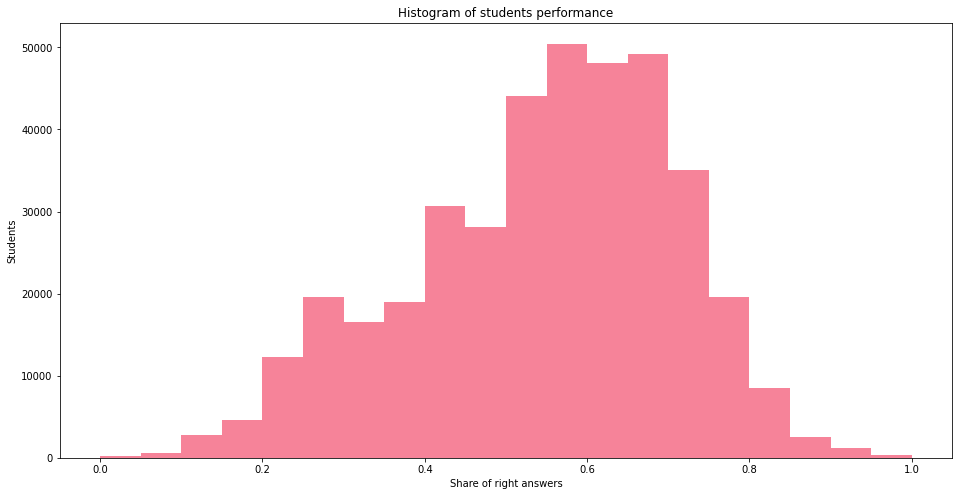

In [8]:
plt.subplots(figsize=(16, 8))
plt.xlabel("Share of right answers")
plt.ylabel("Students")
plt.title("Histogram of students performance")
plt.hist(answer_counts["right_answers_%"], bins = 20, color = "#f34e6e", alpha = 0.7)
plt.show()

Основная масса студентов (середнячки) отвечает правильно на 50 - 80 % теста. Отличников (больше 80%) не так много.

## Посмотрим как влияют свойства вопросов на успеваемость

### Выгрузим данные в агрегированном виде по вопросам

In [9]:
q_answer_counts = pd.DataFrame()
with pd.read_csv("data/train.csv", index_col = "row_id", chunksize = 100000) as reader:
    for chunk in reader:
        df = chunk[chunk["content_type_id"]==0]\
                .groupby(["content_id", "task_container_id"])\
                         .agg(right_answers=("answered_correctly","sum"),
                              total_answers=("answered_correctly","count"))
        q_answer_counts = pd.concat([q_answer_counts, df], axis=0)
                                    
# Повторно группируем и суммируем по пользователю, так как отдельные пользователи могли попасть в разные чанки        
q_answer_counts = q_answer_counts.groupby(["content_id", "task_container_id"])\
                                    .agg(right_answers=("right_answers","sum"),
                                         total_answers=("total_answers","sum"))

In [10]:
q_answer_counts.reset_index(inplace = True)
q_answer_counts.rename(columns = {'content_id': 'question_id'}, inplace = True)
q_answer_counts = q_answer_counts.merge(questions,
                                      how='left',
                                      on='question_id')
q_answer_counts.head()

,question_id,task_container_id,right_answers,total_answers,bundle_id,correct_answer,part,tags
0,0,0,2,2,0,0,1,51 131 162 38
1,0,1,40,47,0,0,1,51 131 162 38
2,0,2,9,10,0,0,1,51 131 162 38
3,0,3,22,24,0,0,1,51 131 162 38
4,0,4,27,36,0,0,1,51 131 162 38


### Оценим влияние part на успеваемость

In [11]:
part_answer_counts = q_answer_counts.groupby("part").agg(right_answers=("right_answers","sum"),
                                     total_answers=("total_answers","sum"))
part_answer_counts["right_answers_%"] = part_answer_counts["right_answers"]/part_answer_counts["total_answers"]
with pd.option_context('display.float_format', '{:,.2%}'.format):
    print(part_answer_counts[['right_answers_%']].sort_values(by = 'right_answers_%'))

      right_answers_%
part                 
5              61.01%
4              63.10%
7              65.96%
6              66.94%
3              70.15%
2              70.87%
1              74.50%


Судя по данным, получается, что часть 1 даётся студентам проще всего, а часть 5 - сложнее всего.
Разные части теста ожидаемо имеют разный уровень сложности. Какие тут могут быть причины:
* Каждая часть теста состоит из ряда однотипных вопросов. Характер вопросов при этом отличается (что-то студентам дайтся проще, что-то сложнее). Например, в первых четырёх частях нужно воспринимать информацию на слух, в последних трёх - работа с текстом.
* В первой части (лучший средний балл) студент отвечает всего на 6 вопросов (данные с сайта о тесте), а в пятой (худший средний балл) - 30 (студенту может быть сложнее концентрироваться так долго).
* Кроме того, на первой части (в начале тестирования) голова ещё "свеженькая" и хорошо соображает, к концу теста мозг может уставать и больше ошибаться.


https://www.iibc-global.org/english/toeic/test/lr/about/format.html

Далее визуализируем, насколько успешно студенты отвечают на вопросы в разных частях теста.

In [12]:
part_q_answer_counts = q_answer_counts.groupby(["part", "question_id"])\
                                      .agg(right_answers=("right_answers","sum"),
                                           total_answers=("total_answers","sum"))
part_q_answer_counts["right_answers_%"] = part_q_answer_counts["right_answers"]/part_q_answer_counts["total_answers"]
part_q_answer_counts.reset_index(inplace = True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


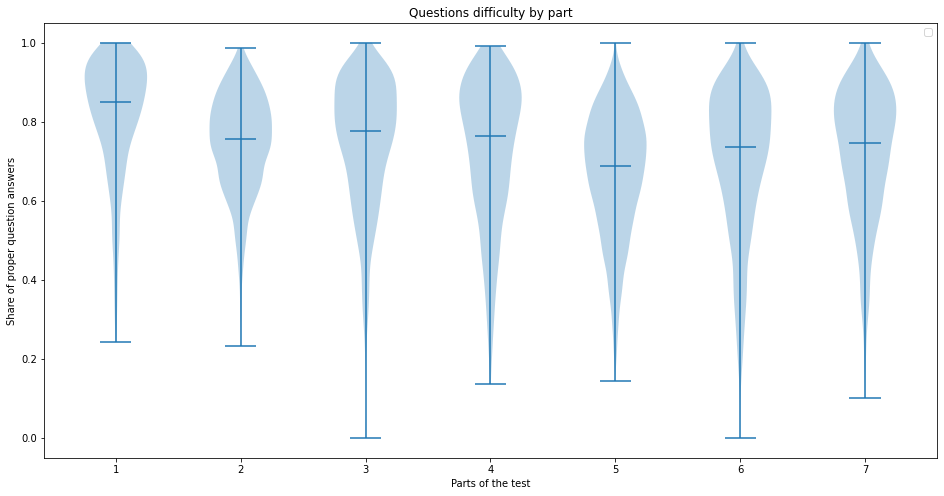

In [13]:
fig, ax = plt.subplots(figsize=(16, 8))
x = list(part_q_answer_counts['part'])
y = [list(part_q_answer_counts[part_q_answer_counts.part==i]['right_answers_%']) for i in range(1,8)]
ax.violinplot(y,
                  showmeans=False,
                  showmedians=True)
ax.set_title('Questions difficulty by part')
ax.set_xlabel("Parts of the test")
ax.set_ylabel("Share of proper question answers")
ax.legend()
plt.show()

Здесь тоже видно, что разные части теста по-разному даются студентам:
* В 3 и 6 группах есть вопросы, на которые никто не смог ответить
* Лучше всего студенты справляются с первой частью.

Посмотрим, что это за вопросы, на которые никто не ответил

In [14]:
part_q_answer_counts[part_q_answer_counts['right_answers_%']==0]

,part,question_id,right_answers,total_answers,right_answers_%
2723,3,1484,0,1,0.0
2724,3,1485,0,1,0.0
2725,3,1486,0,1,0.0
11560,6,10007,0,1,0.0


По этим вопросам было собрано всего одно наблюдение! По таким единичным наблюдениям нельзя судить о степени сложности вопроса, поэтому далее исключим их из выборки.
Какое количество накопленных ответов считать достаточным? Посмотрим, что нам скажет метод describe.

In [15]:
part_q_answer_counts["total_answers"].describe(percentiles=[.05, .1, .15,.25, .5, .75])

count     13523.000000
mean       7340.922872
std       11455.927774
min           1.000000
5%          153.000000
10%         283.000000
15%         913.000000
25%        1765.500000
50%        4732.000000
75%        8556.000000
max      213605.000000
Name: total_answers, dtype: float64

Чтобы не удалять слшком много вопросов, попробуем оставить только те вопросы, на которые было дано от 150 ответов (отрежем ~5% самых непопулярных вопросов). И посмотрим, как измениться график.

In [16]:
part_q_answer_counts = part_q_answer_counts[part_q_answer_counts["total_answers"]>=150]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


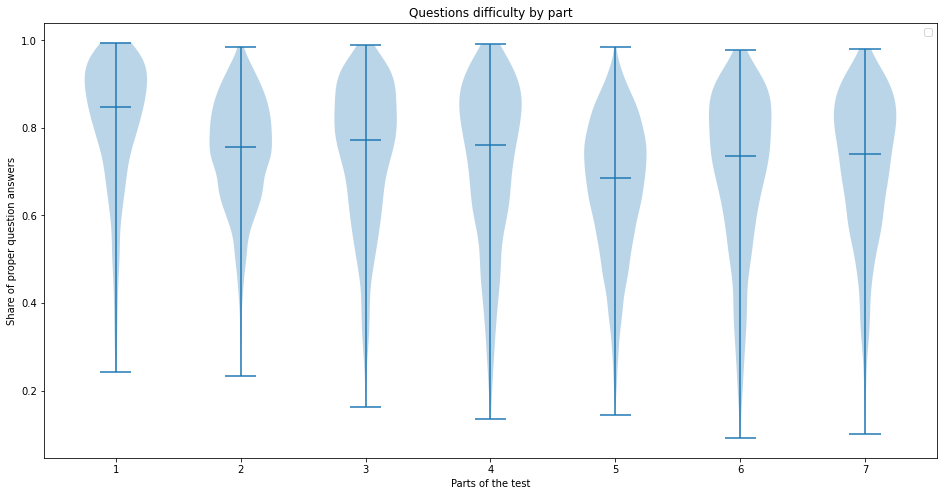

In [17]:
fig, ax = plt.subplots(figsize=(16, 8))
x = list(part_q_answer_counts['part'])
y = [list(part_q_answer_counts[part_q_answer_counts.part==i]['right_answers_%']) for i in range(1,8)]
ax.violinplot(y,
                  showmeans=False,
                  showmedians=True)
ax.set_title('Questions difficulty by part')
ax.set_xlabel("Parts of the test")
ax.set_ylabel("Share of proper question answers")
ax.legend()
plt.show()

Картинка существенно не изменилась. Первая часть по-прежнему определяется как самая простая, пятая - как самая сложная. Остальные части примерно на одном уровне сложности.

**Для прогнозирования вероятности правильного ответа можно попробовать использовать фичу части теста одним их двух вариантов и выбрать тот, с которым получается лучший результат:**
* вариант А - каждой части теста соответствует своя категория
* вариант Б - поделить части на 3 категоррии: сложная (часть 5), простая (часть 1) и средние (все остальные)

### Оценим влияние bundle_id на успеваемость

In [18]:
bundles_per_question = q_answer_counts[['bundle_id', 'question_id']].drop_duplicates().groupby('question_id').size().sort_values()
questions_per_bundle = q_answer_counts[['bundle_id', 'question_id']].drop_duplicates().groupby('bundle_id').size().sort_values()
print("В одном bundle может быть вопросов: {}".format(str(questions_per_bundle.unique())))
print("Один вопрос может попадать в {} bundle".format(str(bundles_per_question.unique())))

В одном bundle может быть вопросов: [1 2 3 4 5]
Один вопрос может попадать в [1] bundle


Каждый вопрос у нас попадает только в один bundle, при этом в одном bundle может находиться от 1 до 5 различных вопросов. Судя по описанию, bundle - это некоторая группа вопросов, которая в тесте появляется совместно. Вероятно, это вопросы к одному и тому же тексту/аудиофрагменту.

In [19]:
bundle_answer_counts = q_answer_counts.groupby(["part", "bundle_id"])\
                                      .agg(right_answers=("right_answers","sum"),
                                           total_answers=("total_answers","sum"))
bundle_answer_counts["right_answers_%"] = bundle_answer_counts["right_answers"]/bundle_answer_counts["total_answers"]
bundle_answer_counts.reset_index(inplace = True)
bundle_answer_counts = bundle_answer_counts[bundle_answer_counts["total_answers"]>=150]

In [20]:
bundle_answer_counts["right_answers_%"].describe()

count    9621.000000
mean        0.703160
std         0.150858
min         0.144753
25%         0.613868
50%         0.723286
75%         0.812993
max         0.994595
Name: right_answers_%, dtype: float64

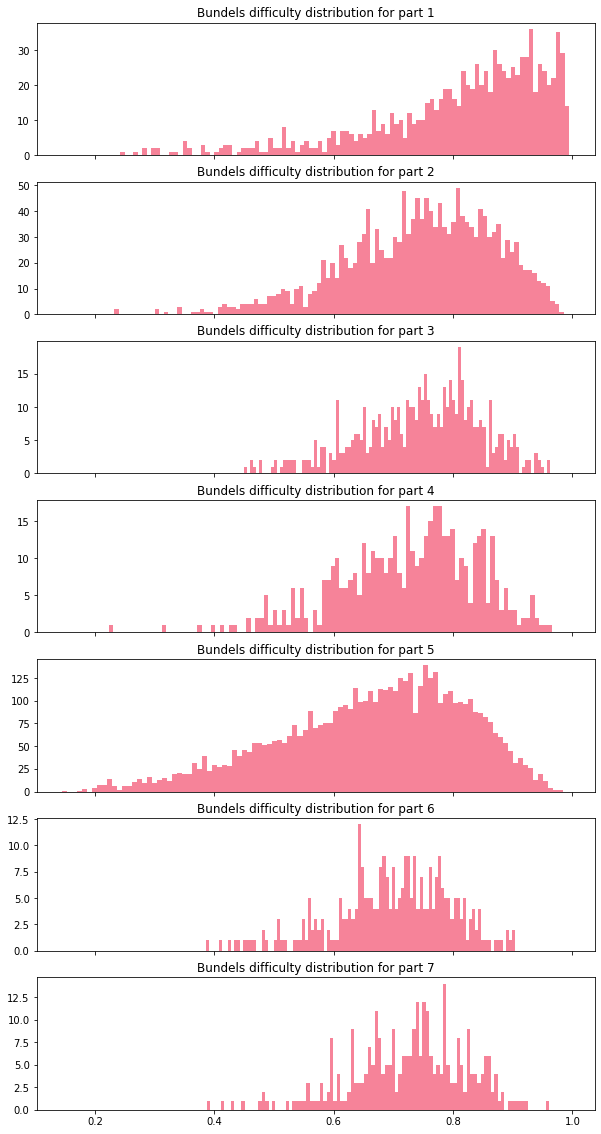

In [21]:
fig, axs = plt.subplots(7, figsize=(10, 20), sharex=True)
for i in range(7):
    axs[i].hist(bundle_answer_counts[bundle_answer_counts["part"]== i+1]["right_answers_%"],
                  bins = 100,
                  color = "#f34e6e",
                  alpha = 0.7
                  )
    axs[i].set_title(f"Bundels difficulty distribution for part {i+1}")
    
plt.show()   

Получается, что для большинства частей сложность bundles основной массе средняя (60-80% правильных ответов). Но есть определённая доля bundles, на которые отвечают хуже (особенно высока доля таких в части 5), и есть категория bundles, на которые отвечают почти все (в первой части смещение явно в эту сторону).

**Для прогнозирования вероятности правильного ответа можно попробовать классифицировать все bundles на несколько категорий сложности по среднему проценту правильных ответов.**

### Посмотрим на task_container_id

In [22]:
tс_per_question = q_answer_counts[['task_container_id', 'question_id']].drop_duplicates().groupby('question_id').size().sort_values()
questions_per_tс = q_answer_counts[['task_container_id', 'question_id']].drop_duplicates().groupby('task_container_id').size().sort_values()
print("В одном task_container_id может быть вопросов: {}".format(str(questions_per_tс.unique())))
print("Один вопрос может попадать в {} task_container_id".format(str(tс_per_question.unique())))

В одном task_container_id может быть вопросов: [  165   169   170 ... 11478 11485 11503]
Один вопрос может попадать в [   1    3    5 ... 4371 4441 4456] task_container_id


Один и тот же вопрос попадает то в один, то в другой task_container_id. Данный атрибут является переменным свойством вопроса и, скорее всего, будет только вносить сумятицу в модель, если использовать его в качестве предсказательной переменной.

### Тэги

In [43]:
tag_answer_count = q_answer_counts.groupby("tags").agg(right_answers=("right_answers","sum"),
                                           total_answers=("total_answers","sum")) #27665376
tag_answer_count.reset_index(inplace = True)
tag_answer_count['tags'] = tag_answer_count['tags'].str.split(' ').tolist()

In [45]:
tag_answer_count = tag_answer_count.explode('tags').groupby("tags").agg(right_answers=("right_answers","sum"),
                                           total_answers=("total_answers","sum"))
tag_answer_count["right_answers_%"] = tag_answer_count["right_answers"]/tag_answer_count["total_answers"]

In [46]:
tag_answer_count["right_answers_%"].describe()

count    188.000000
mean       0.666052
std        0.081571
min        0.385725
25%        0.620568
50%        0.677909
75%        0.714171
max        0.863945
Name: right_answers_%, dtype: float64

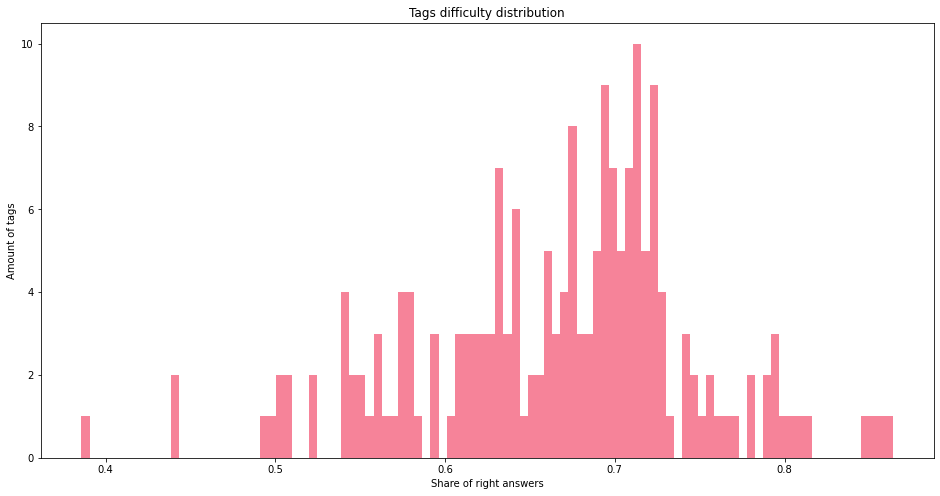

In [47]:
plt.subplots(figsize=(16, 8))
plt.xlabel("Share of right answers")
plt.ylabel("Amount of tags")
plt.title("Tags difficulty distribution")
plt.hist(tag_answer_count["right_answers_%"], bins = 100, color = "#f34e6e", alpha = 0.7)
plt.show()

In [50]:
print("Отсортируем теги по сложности")
display(tag_answer_count.sort_values(by = "right_answers_%"))

Отсортируем теги по сложности


,right_answers,total_answers,right_answers_%
tags,,,
24,98982,256613,0.385725
23,204293,465904,0.438487
19,136367,309969,0.439938
151,264913,537180,0.493155
167,170681,341067,0.500432
...,...,...,...
40,184338,226514,0.813804
149,336639,396973,0.848015
130,207920,243708,0.853152


По тегам тоже есть ряд тегов, на вопросы по которым отвечают почти все правильно(например, 187, 68). И наоборот, есть теги, которые вызывают затруднения у существенной части студентов (например 24 и 23).

**Для прогнозирования правильности ответа теги также имеет смысл распределить по категорим сложности.**

## Проанализируем, насколько посещение лекций помогает студентам правильно отвечать на вопросы

### Соберём статистику по пользователям - какие лекции они посетили

In [72]:
lecture_attendance = pd.DataFrame()
with pd.read_csv("data/train.csv", index_col = "row_id", chunksize = 100000) as reader:
    for chunk in reader:
        df = chunk[chunk['content_type_id']==1][['timestamp', 'user_id', 'content_id', 'task_container_id']]
        df.rename(columns = {'content_id': 'lecture_id'}, inplace = True)
        df = df.merge(lectures, how='left', on='lecture_id')
        lecture_attendance = pd.concat([lecture_attendance, df], axis=0)
#lecture_attendance['type_of'] = lecture_attendance['type_of'].astype('category')

In [59]:
lecture_attendance.head()

,timestamp,user_id,lecture_id,task_container_id,tag,part,type_of
0,653762,2746,6808,14,129,2,intention
1,10183847,5382,16736,21,40,1,concept
2,1424348597,5382,30207,104,43,5,concept
3,1425557777,5382,18545,121,58,5,concept
4,405813029,8623,10540,59,99,1,concept


In [61]:
set(lecture_attendance.type_of)

{'concept', 'intention', 'solving question', 'starter'}

### Попробуем оценить, есть ли зависимость между фактом посещения лекций разных типов по той или иной части теста и успеваемостью студента по этой части теста.

In [ ]:
# Выгрузим успеваемость пользователей в разрезе частей теста
up_answer_counts = pd.DataFrame()
with pd.read_csv("data/train.csv", index_col = "row_id", chunksize = 100000) as reader:
    for chunk in reader:
        df = chunk[chunk["content_type_id"]==0]
        df.rename(columns = {'content_id': 'question_id'}, inplace = True)
        df = df.merge(questions, how='left', on='question_id')\
               .groupby(["user_id", "part"])\
               .agg(right_answers=("answered_correctly","sum"),
                    total_answers=("answered_correctly","count"))
        up_answer_counts = pd.concat([up_answer_counts, df], axis=0)
                                    
# Повторно группируем и суммируем по пользователю, так как отдельные пользователи могли попасть в разные чанки        
up_answer_counts = up_answer_counts.groupby(["user_id", "part"])\
                                    .agg(right_answers=("right_answers","sum"),
                                         total_answers=("total_answers","sum"))

In [73]:
up_answer_counts["right_answers_%"] = up_answer_counts["right_answers"]/up_answer_counts["total_answers"]
up_answer_counts.reset_index(inplace = True)
df = up_answer_counts.merge(lecture_attendance[["user_id", "part", "type_of"]].drop_duplicates(),
                      on = ["user_id", "part"],
                      how = "left")
df.fillna({"type_of": "no_lectures"}, inplace = True)

In [83]:
df = df.pivot_table(index = 'part', columns = 'type_of', values =  'right_answers_%', aggfunc='mean')
df

type_of,concept,intention,no_lectures,solving question,starter
part,,,,,
1,0.710884,NaN,0.596246,0.696273,NaN
2,0.665166,0.670316,0.645366,0.663303,NaN
3,0.680580,NaN,0.513266,0.669473,NaN
4,0.651106,NaN,0.411637,0.644944,NaN
5,0.579284,NaN,0.459398,0.587315,0.501319
6,0.646987,NaN,0.514396,0.639798,0.560363
7,0.644476,NaN,0.480490,0.623143,NaN


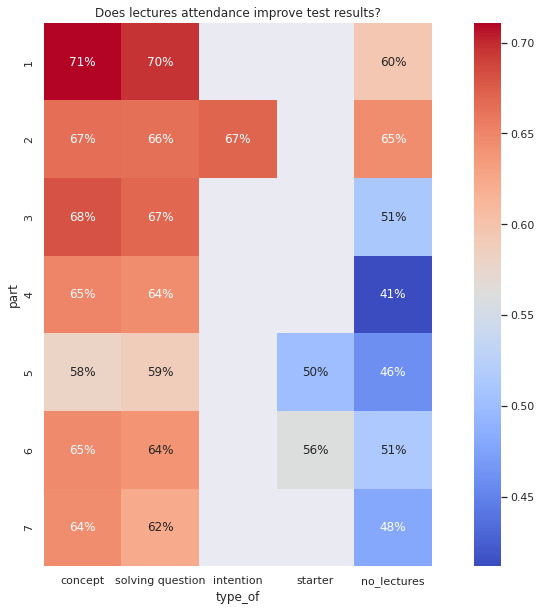

In [85]:
sns.set(rc = {"figure.figsize": (15, 10)})
ax = sns.heatmap(df[["concept", "solving question", "intention", "starter", "no_lectures"]],
                 cmap = 'coolwarm',
                 square = True,
                 annot = True,
                 fmt = ".0%"
)
plt.title("Does lectures attendance improve test results?")
plt.show()

**Результаты у студентов, посещавших лекции во всех случаях выше, чем у студентов, не посещавших лекции.**